In [1]:
import os

# List all files in the dataset directory
base_path = '/kaggle/input/cleaneddata/cleaned_train_copy.csv'

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

dataset = pd.read_csv(base_path)
dataset.head(5)

,id,Basic_Demos-Age,Basic_Demos-Sex,age_group,CGAS_Score,Physical-BMI,BIA_Activity_Level,Fitness_Combined_Score,Physical_Composite_Index,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,5,0,Child,51.000000,16.877316,2.0,0.200000,0.184805,64.4,3.0,2.0
1,000fd460,9,0,Early Teen,65.156829,14.035590,2.0,0.400000,0.178587,64.0,0.0,0.0
2,00105258,10,1,Early Teen,65.156829,19.131648,3.0,0.583126,0.193319,54.0,2.0,0.0
3,00115b9f,9,0,Early Teen,71.000000,18.292347,3.0,0.400000,0.190185,45.0,0.0,1.0
4,001f3379,13,1,Teen,50.000000,22.279952,2.0,0.400000,0.217322,56.0,0.0,1.0


In [2]:
dataset.drop(['age_group','id'], axis=1, inplace=True)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.preprocessing import label_binarize

The results indicate some improvement in classifying the minority classes, but the overall performance still reflects challenges in dealing with the class imbalance, especially for classes 1.0, 2.0, and 3.0

Class 0.0 (Majority Class):
Good precision, recall, and F1-score, as expected, since it's overrepresented.
Class 1.0 and 2.0 (Minority Classes):
Precision and recall are low, indicating difficulty in distinguishing these classes.
Class 3.0 (Highly Minority):
Recall is high but precision is very poor, likely due to oversampling by SMOTE leading to overfitting for this class.

Recommendations and Updates
Advanced Resampling Strategy:
Instead of plain SMOTE, use SMOTE-Tomek or ADASYN, which refine synthetic sample generation to reduce noise.
Hyperparameter Tuning:
Adjust SVM parameters (C, gamma, kernel) using GridSearchCV or RandomizedSearchCV to find optimal values.
Custom Kernel:
Experiment with a polynomial or sigmoid kernel to improve separability.
Ensemble Techniques:
Combine SVM with other classifiers (e.g., Random Forest, Gradient Boosting) using an ensemble method like voting or stacking.
Evaluation Metrics:
Visualize precision-recall and ROC curves per class.
Data Preprocessing:
Apply feature selection or engineering to better separate the minority classes.
Class-Specific Threshold Tuning:
Adjust decision thresholds for each class based on ROC curves to balance precision and recall.

In [4]:
from imblearn.combine import SMOTETomek
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

X, y = dataset.drop(columns=['sii']), dataset['sii']  # Replace 'sii' with target column
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42, stratify=y)
# Step 1: Advanced Resampling with SMOTE-Tomek
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

# Step 2: Hyperparameter Tuning for SVM
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}
grid_search = GridSearchCV(SVC(probability=True, class_weight='balanced', random_state=42),
                           param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)



Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [5]:
# Train SVM with best parameters
svm_model = SVC(**best_params, probability=True, class_weight='balanced', random_state=42)
svm_model.fit(X_resampled, y_resampled)



SVC(C=10, class_weight='balanced', gamma=0.1, probability=True, random_state=42)

In [6]:
# Step 4: Predictions
y_pred = svm_model.predict(X_test)
y_prob = svm_model.predict_proba(X_test)



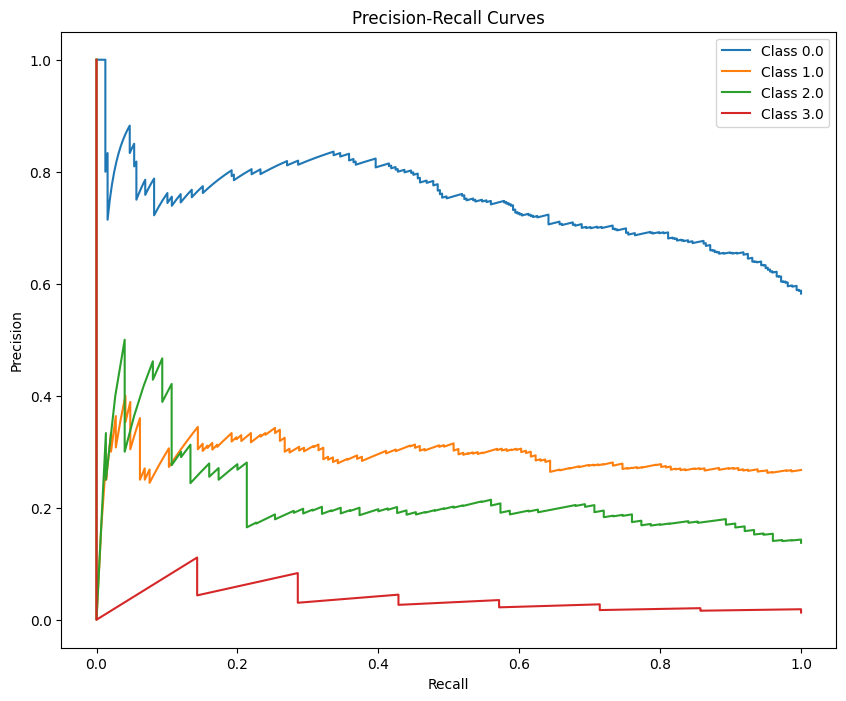

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [7]:
# Evaluate Precision-Recall and ROC Curves for each class
plt.figure(figsize=(10, 8))
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
for i, class_label in enumerate(np.unique(y)):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f"Class {class_label}")
plt.title("Precision-Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))


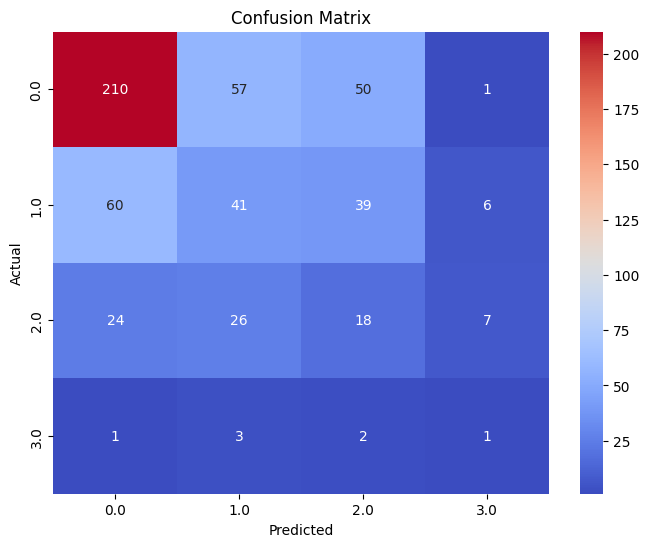

In [8]:
# Updated Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="coolwarm", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


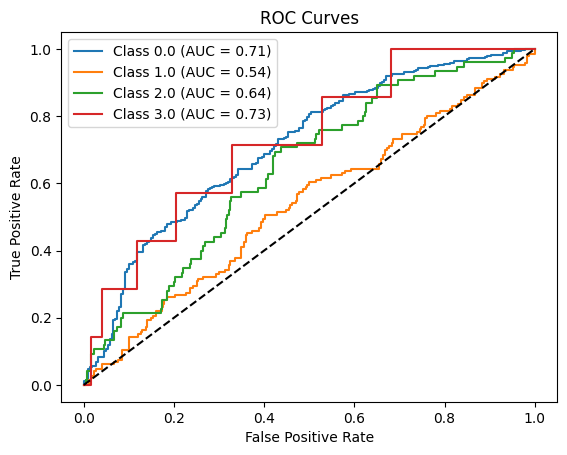

In [9]:
roc_auc_scores = roc_auc_score(y_test_binarized, y_prob, average=None)
for i, class_label in enumerate(np.unique(y)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc_scores[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()



In [10]:
# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.4945054945054945
Classification Report:
               precision    recall  f1-score   support

         0.0       0.71      0.66      0.69       318
         1.0       0.32      0.28      0.30       146
         2.0       0.17      0.24      0.20        75
         3.0       0.07      0.14      0.09         7

    accuracy                           0.49       546
   macro avg       0.32      0.33      0.32       546
weighted avg       0.52      0.49      0.51       546

Confusion Matrix:
 [[210  57  50   1]
 [ 60  41  39   6]
 [ 24  26  18   7]
 [  1   3   2   1]]
